In [0]:
import numpy as np
import pandas as pd
import re, torch, time
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/INF8111/data/preprocess_2classes.pkl")

In [53]:
pos_weight = len(data.loc[data["label"]==0]) / len(data.loc[data["label"]==1])
print(pos_weight)

21.472016895459344


Text(0.5, 1.0, 'Sequence length distribution')

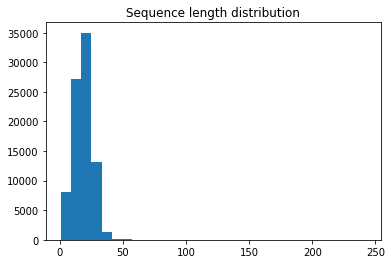

In [23]:
plt.hist([len(x) for x in data.tweet], bins=30)
plt.title("Sequence length distribution")

In [0]:
vocab_max = 50000
seq_length = 30
count_words = Counter()
for tweet in data.tweet:
    for tok in tweet:
        count_words[tok] +=1
vocab = {w for w,_ in count_words.most_common(vocab_max-2)}.union( {"UNK", "PAD"})
word2val = {w : i+2 for i, (w,_) in enumerate( count_words.most_common(vocab_max-2) )}
word2val["PAD"] = 0
word2val["UNK"] = 1
X = []
for tweet in data.tweet:
    tmp = [word2val[tok] if tok in vocab else word2val["UNK"] for tok in tweet]
    if len(tmp) > seq_length:
        X.append(tmp[:seq_length])
    else:
        X.append([0 for _ in range(seq_length - len(tmp))] + tmp)
X = np.array(X)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, np.array(data.label), test_size=0.33, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_valid = torch.tensor(y_valid)
y_test = torch.tensor(y_test)
train_data = torch.utils.data.TensorDataset(X_train, y_train)
valid_data = torch.utils.data.TensorDataset(X_valid, y_valid)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

In [0]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [0]:
def compute_accuracy(model, data_loader):
  correct = 0
  for i, (X_batch, y_batch) in enumerate(data_loader):
    torch.cuda.empty_cache()
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    out = model.forward(X_batch.to(device))
    correct += (torch.max(out, 1)[1] == y_batch).float().sum()
  return((100*correct/len(test_loader.dataset)).item())
  
def compute_scores(model, data_loader):
  y_hat = []
  y = []
  for i, (X_batch, y_batch) in enumerate(data_loader):
    torch.cuda.empty_cache()
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    out = model.forward(X_batch.to(device))
    out = (torch.sigmoid(out) > 0.5).float() 
    y_hat = y_hat + out.squeeze().tolist()
    y = y + y_batch.tolist()
  prec = metrics.precision_score(y, y_hat)
  recall = metrics.recall_score(y, y_hat)
  f1 = metrics.f1_score(y, y_hat)
  return prec, recall, f1


In [0]:
class RNN(nn.Module):
    def __init__(self,
                 emb_size,
                 hidden_size,
                 vocab_size,
                 num_layers,
                 nonlinearity = 'relu',
                 bias = True,
                 dropout = 0,
                 bidirectional = True
                ):
        super(RNN, self).__init__()
        #hyper-parameters
        self.emb_size      = emb_size
        self.hidden_size   = hidden_size
        self.vocab_size    = vocab_size
        self.num_layers    = num_layers
        self.nonlinearity  = nonlinearity
        self.bias          = bias
        self.dropout       = dropout
        self.bidirectional = bidirectional
        #layers
        self.embedding = nn.Embedding(vocab_size, emb_size).to(device)
        self.rnn = nn.GRU(input_size = emb_size,
                          hidden_size = hidden_size,
                          num_layers = num_layers,
                          bias = bias,
                          dropout = dropout,
                          bidirectional = bidirectional
                         ).to(device)
        self.linear = nn.Linear((bidirectional+1) *hidden_size, 1).to(device)
        
    def forward(self, X):
        out = self.embedding(X.t())
        out, _ = self.rnn(out)
        return self.linear(out[-1])

In [0]:
rnn = RNN( emb_size = 512,
         hidden_size = 512,
         vocab_size = vocab_max,
         num_layers = 4,
         nonlinearity = 'tanh',
         dropout = 0.5,
         bidirectional=True)

In [0]:
# criterion = nn.CrossEntropyLoss(weight=torch.tensor(weight_balance).to(device))
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight).to(device))
optimizer = torch.optim.Adam(rnn.parameters(),weight_decay=10e-5)

In [75]:
n_epochs = 10
start_time = time.time()
last_time = time.time()
for epoch in range(1, n_epochs+1):
    print("Epoch: {}/{}".format(epoch, n_epochs))
    running_loss = 0
    correct = 0
    for i, (X_batch, y_batch) in enumerate(train_loader):
        torch.cuda.empty_cache()
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        out = rnn.forward(X_batch.to(device))
        loss = criterion(out.squeeze(), y_batch.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (torch.max(out, 1)[1] == y_batch).float().sum()
        # if time.time() - last_time > 0.5:
        #     print("Samples:{}/{}\tloss: {:.4f}\tacc: {:2.3f}\telapsed_time: {:.1f}s"\
        #           .format( (i+1)*batch_size, len(train_loader.dataset),\
        #                   running_loss/((i+1)*batch_size), 100*correct/((i+1)*batch_size), time.time()-start_time), end='\r')
        #     last_time = time.time()
    prec, recall, f1 = compute_scores(rnn, valid_loader)
    print("Samples:{}/{}\tloss: {:.4f}\tacc: {:2.3f}\telapsed_time: {:.1f}s\tvalid_acc: {:2.3f}\tprec: {}\trecall: {}\tf1: {}"\
          .format( (i+1)*batch_size, len(train_loader.dataset),\
                  running_loss/((i+1)*batch_size), 100*correct/((i+1)*batch_size), time.time()-start_time,
                  compute_accuracy(rnn, valid_loader), prec, recall, f1), flush=True)

Epoch: 1/10
Samples:57056/57033	loss: 0.0343	acc: 95.517	elapsed_time: 128.7s	valid_acc: 95.493	prec: 0.23703703703703705	recall: 0.35443037974683544	f1: 0.2840837032339886
Epoch: 2/10
Samples:57056/57033	loss: 0.0316	acc: 95.517	elapsed_time: 267.7s	valid_acc: 95.493	prec: 0.11248785228377065	recall: 0.7325949367088608	f1: 0.19502948609941026
Epoch: 3/10
Samples:57056/57033	loss: 0.0306	acc: 95.517	elapsed_time: 406.8s	valid_acc: 95.493	prec: 0.15421245421245422	recall: 0.6661392405063291	f1: 0.25044616299821537
Epoch: 4/10
Samples:57056/57033	loss: 0.0295	acc: 95.517	elapsed_time: 545.7s	valid_acc: 95.493	prec: 0.132873425314937	recall: 0.7009493670886076	f1: 0.22339889056984366
Epoch: 5/10


KeyboardInterrupt: ignored

In [0]:
def compute_scores(model, data_loader):
  y_hat = []
  y = []
  for i, (X_batch, y_batch) in enumerate(data_loader):
    torch.cuda.empty_cache()
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    out = model.forward(X_batch.to(device))
    out = (torch.sigmoid(out) > 0.5).float() 
    y_hat = y_hat + out.squeeze().tolist()
    y = y + y_batch.tolist()
  prec = metrics.precision_score(y, y_hat)
  recall = metrics.recall_score(y, y_hat)
  f1 = metrics.f1_score(y, y_hat)
  return prec, recall, f1
